## Image Classification on MNIST dataset 😼

### Import libraries

In [1]:
import numpy as np
import torch
import torchvision
from torchvision.transforms import v2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Create transform for image transformation

In [2]:
# https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#i-just-want-to-do-image-classification

transforms = v2.Compose(
    [
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((0.5,), (0.5,)),
    ]
)

### get dataset & pass it into `DataLoader`

In [3]:
# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.MNIST(
    "./data", train=True, transform=transforms, download=True
)
validation_set = torchvision.datasets.MNIST(
    "./data", train=False, transform=transforms, download=True
)

# Class labels
classes = ("0","1","2","3","4","5","6","7","8","9")


# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=4, shuffle=False
)
print("Training set has {} instances".format(len(training_set)))
print("Validation set has {} instances".format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


### Visualize data

4  5  9  1


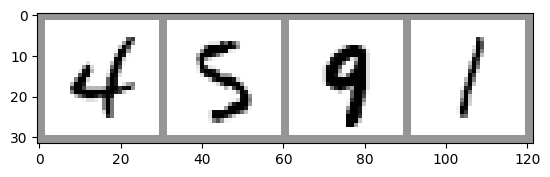

In [4]:
import matplotlib.pyplot as plt
import numpy as np


# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  # un-normalize
    np_img = img.numpy()
    if one_channel:
        plt.imshow(np_img, cmap="Greys")
    else:
        plt.imshow(np.transpose(np_img, (1, 2, 0)))


data_iter = iter(training_loader)
images, labels = next(data_iter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print("  ".join(classes[labels[j]] for j in range(4)))

In [5]:
print(f"{type(images)=}, {type(images[0])=}")
print(f"{images.shape=}, {images[0].shape=}")

type(images)=<class 'torch.Tensor'>, type(images[0])=<class 'torch.Tensor'>
images.shape=torch.Size([4, 1, 28, 28]), images[0].shape=torch.Size([1, 28, 28])


---

### Let's start working on Classification Model 🦅

In [6]:
import torch.nn as nn
import torch.nn.functional as F


# PyTorch models inherit from torch.nn.Module
class MNISTDigitClassifier(nn.Module):
    def __init__(self):
        super(MNISTDigitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # input= 1*28*28; output=6*24*24 (28-5+1)
        self.pool = nn.MaxPool2d(2, 2)  # input= 6*24*24; output=6*12*12 (24/2)
        self.conv2 = nn.Conv2d(6, 16, 5)  # input= 6*12*12; output=16*8*8 (12-5+1)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # after applying `self.pool`, 8/2 = 4. hence input (16*4*4)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = MNISTDigitClassifier()

In [7]:
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [8]:
def train_one_epoch(epoch_index):
    running_loss = 0.0
    last_loss = 0.0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000  # loss per batch
            print("  batch {} loss: {}".format(i + 1, last_loss))
            running_loss = 0.0

    return last_loss

In [9]:
# Initializing in a separate cell so we can easily add more epochs to the same run
epoch_number = 0

EPOCHS = 5

best_v_loss = 1_000_000.0

for epoch in range(EPOCHS):
    print("EPOCH {}:".format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)

    running_v_loss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, v_data in enumerate(validation_loader):
            v_inputs, v_labels = v_data
            v_outputs = model(v_inputs)
            v_loss = loss_fn(v_outputs, v_labels)
            running_v_loss += v_loss

    avg_v_loss = running_v_loss / (i + 1)
    print("LOSS train {} valid {}".format(avg_loss, avg_v_loss))

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 2.226339557170868
  batch 2000 loss: 0.5958444049882237
  batch 3000 loss: 0.23605732675496255
  batch 4000 loss: 0.20026526714742068
  batch 5000 loss: 0.16192948211650945
  batch 6000 loss: 0.1307777889623394
  batch 7000 loss: 0.12480625421863806
  batch 8000 loss: 0.10924859576005111
  batch 9000 loss: 0.11495323218681733
  batch 10000 loss: 0.09936129642137258
  batch 11000 loss: 0.09368240399639853
  batch 12000 loss: 0.08997721097101384
  batch 13000 loss: 0.07505084206145875
  batch 14000 loss: 0.07405015431157062
  batch 15000 loss: 0.08197358615349822
LOSS train 0.08197358615349822 valid 0.0721864104270935
EPOCH 2:
  batch 1000 loss: 0.06785109511365954
  batch 2000 loss: 0.06409733097257492
  batch 3000 loss: 0.05748421202773443
  batch 4000 loss: 0.06886262311048086
  batch 5000 loss: 0.06106553748343231
  batch 6000 loss: 0.06830547609732003
  batch 7000 loss: 0.06278081909209596
  batch 8000 loss: 0.06993525355995461
  batch 9000 loss: 0.059062

## Visualize model predictions 🚀

In [11]:
def visualize_model_predictions():
    # torch.manual_seed(42)

    my_idx = torch.randint(high=len(validation_set), size=(5,))
    print(f"my random indexes are: {my_idx}")

    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i in my_idx:
            curr_image, actual_label = validation_set[i]
            prediction = model(transforms(curr_image))
            predicted_label = prediction.argmax().item()
            color = "red"
            if actual_label==predicted_label:
                color="green"
            # first transform the image and then let model predict
            plt.imshow(curr_image.permute(1, 2, 0))
            plt.title(f"{actual_label=}; {predicted_label=}", color=color)
            plt.axis('off')
            plt.show()

my random indexes are: tensor([8356, 7029, 7120, 2149, 9450])


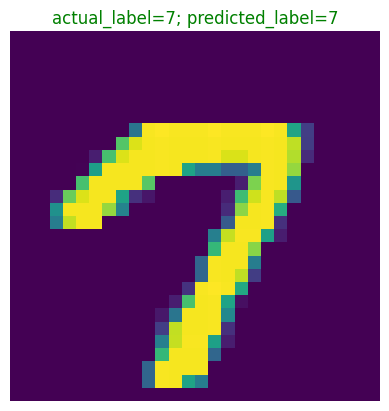

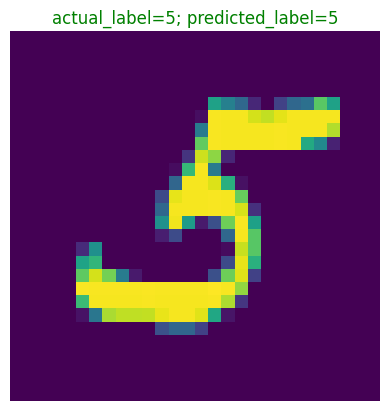

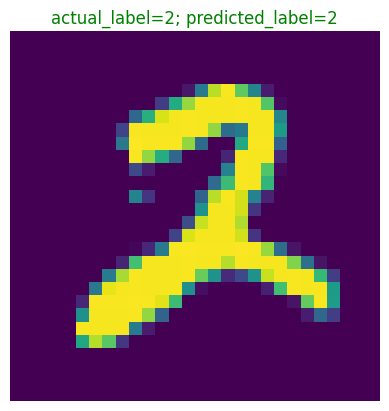

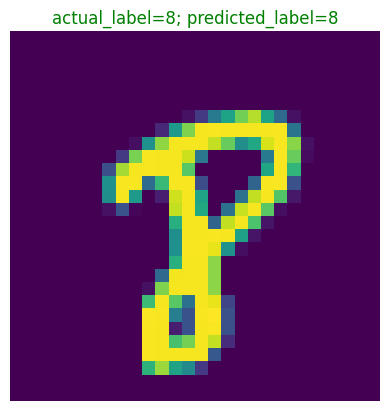

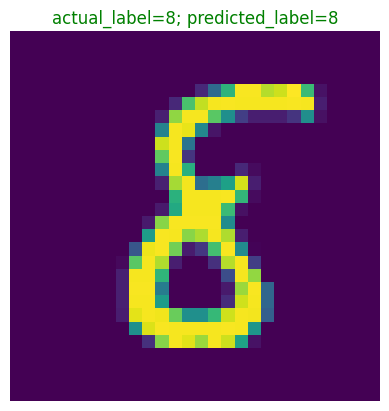

In [12]:
visualize_model_predictions()